In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

# Test simple thermal model

- using measured internal (washing machine) and external temperature (using open energy monitor)
- no heating

In [6]:
# Load data
filename = 'temperature_emonCMS_7clem_032020.csv'

data = np.genfromtxt(filename, delimiter=',', skip_header=1)

time_sec, T_int_raw, T_ext_raw = data.T
time_hour = time_sec/60/60

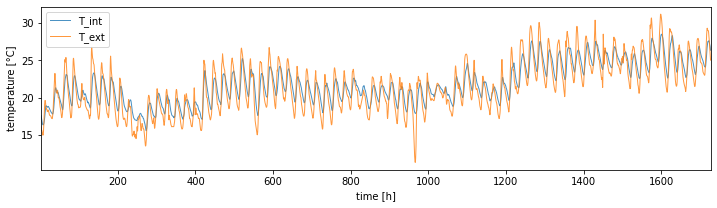

In [7]:
# Interpolation to regular time sampling
dt = 0.5  # hour
time = np.arange(time_hour.min(), time_hour.max(), dt)

T_int = interp1d(time_hour, T_int_raw, kind='cubic')(time)
T_ext = interp1d(time_hour, T_ext_raw, kind='cubic')(time)

# Graph
plt.figure(figsize=(12, 3));
plt.plot(time, T_int, label='T_int', linewidth=1, alpha=0.8);
plt.plot(time, T_ext, label='T_ext', linewidth=1, alpha=0.8);
plt.xlim([np.min(time), np.max(time)])
plt.legend(); plt.xlabel('time [h]'); plt.ylabel('temperature [°C]');

## 1. Raw data linearization

- one parameter: k/M
- i.e. numerical derivative instead of model solving&fitting

k/M: 0.20007766957134632
std residuals: 0.1913470094706596


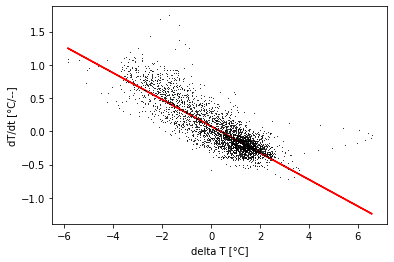

In [8]:
# Plot dT/dt = -k/M (T-T_ext)
# Explicit euler difference scheme:
dT_int_dt = np.diff(T_int)/(dt)  # °C/hour !!
delta_T = (T_int - T_ext)[1:]
a, b = np.polyfit(delta_T, dT_int_dt, 1)

plt.plot(delta_T, a*delta_T + b, 'r')
plt.plot(delta_T, dT_int_dt, ',k', alpha=0.8);
plt.xlabel('delta T [°C]'); plt.ylabel('dT/dt [°C/--]');

print('k/M:', -a)
# k/M: -0.0033802916843788102
# k/M: -0.003296313577964965

residuals = (a*delta_T + b) - dT_int_dt
print('std residuals:', np.std(residuals))

## 2. Solving 1 parameter linear equation using FFT 

In [164]:
from scipy.fft import fft, ifft, fftfreq
from scipy.optimize import least_squares

 active_mask: array([0.])
        cost: 965.7776987086902
         fun: array([8.64686191, 7.47462246, 6.5853686 , ..., 0.61988975, 0.54608181,
       0.66764892])
        grad: array([0.2176664])
         jac: array([[ -3.81036186],
       [ -8.21238232],
       [-11.10587478],
       ...,
       [  0.603652  ],
       [ -0.50472164],
       [ -0.97589636]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 10
        njev: 10
  optimality: 0.21766639670825272
      status: 2
     success: True
           x: array([0.24669256])


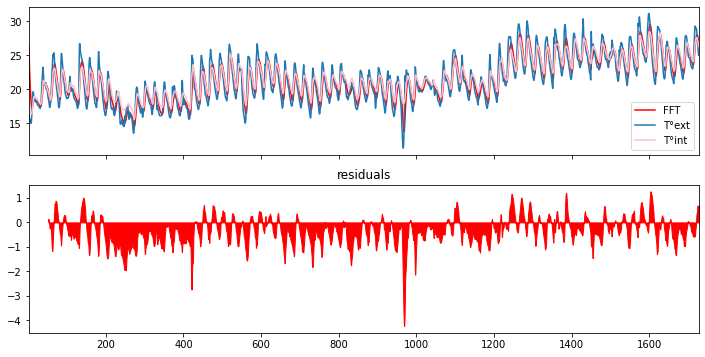

In [165]:
TF_ext = fft(T_ext)
freq = fftfreq(len(T_ext), d=dt)

def solve_1param(a):
    H = 1/(1 + a*2*np.pi*1j*freq)
    TF_int_theo = H * TF_ext
    T_int_theo = np.abs( ifft(TF_int_theo) )
    return T_int_theo

def residuals_1param(kM):
    T = solve_1param(1/kM)
    return T - T_int

res = least_squares(residuals_1param, 0.3)
print(res)

# Graphs
T_int_theo = solve_1param(1/res.x)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax1.plot(time, T_int_theo, label='FFT', color='red')
ax1.plot(time, T_ext, '-', label='T°ext')
ax1.plot(time, T_int, '-', label='T°int', color='pink')
ax1.legend()
ax1.set_xlim([np.min(time), np.max(time)]);

# Residuals
R = T_int_theo - T_int
ax2.fill_between(time[100:], R[100:], color='r');
ax2.set_title('residuals');
ax2.set_xlim([np.min(time), np.max(time)]);

In [166]:
print('k/M:', res.x[0])
print('sum square residuals:', np.sum(R**2))

k/M: 0.24669256315609842
sum square residuals: 1931.5553974173804


## 3. Solve the ODE

In [206]:
%load_ext autoreload
%autoreload 2
from pythsolver import solve_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [207]:
def solve_1R1C(params):
    k1, T01 = params
    
    # name, mass, T0
    nodes = [('int', 1.0, T01), ]

    sources = {'ext':T_ext}

    internal_links = []  #('int', 'wall', k2), ]
    external_links = [('int', 'ext', k1), ] # ext. second

    T = solve_model(nodes,
                    internal_links,
                    external_links,
                    sources,
                    dt)
    return T


def cost_1R1C(x, *params):
    return solve_1R1C(params)[0, :]

p0 = [0.3, T_int[0]]
popt, pcov = curve_fit(cost_1R1C, time, T_int, p0=p0)
print('popt:', popt)
# 5.32 s

popt: [ 0.22960035 18.03939959]


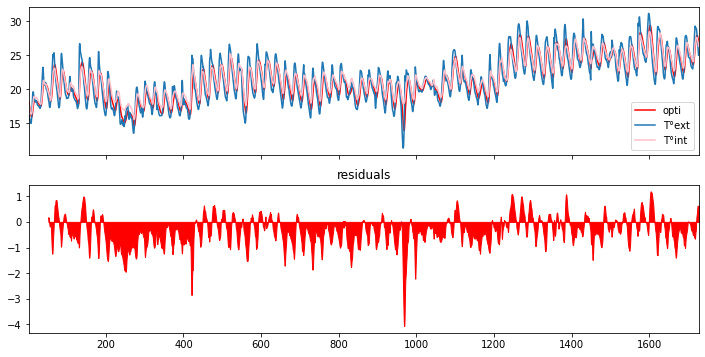

In [208]:
# Graphs
T_int_theo = solve_1R1C(popt)[0, :]

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax1.plot(time, T_int_theo, label='opti', color='red')
ax1.plot(time, T_ext, '-', label='T°ext')
ax1.plot(time, T_int, '-', label='T°int', color='pink')
ax1.legend()
ax1.set_xlim([np.min(time), np.max(time)]);

# Residuals
R = T_int_theo - T_int
ax2.fill_between(time[100:], R[100:], color='r');
ax2.set_title('residuals');
ax2.set_xlim([np.min(time), np.max(time)]);

In [209]:
print('k/M:', res.x[0])
print('sum square residuals:', np.sum(R**2))

k/M: 0.24669256315609842
sum square residuals: 1615.7395693458457


## 3. 2R2C, a 3 parameters model

A second thermal mass is added.  
The parameters are now (k1, k2, M1, M2, T01, T02)  
however, only 3 parameters can be determined

In [212]:
M1 = 1.0
T01 = T_int[0]

def solve_2R2C(params):
    M2, k1, k2, T02 = params
    
    nodes = [('int', M1, T01), # name, mass, T0
             ('wall', M2, T02)]

    sources = {'ext':T_ext}

    internal_links = [('int', 'wall', k2), ]
    external_links = [('int', 'ext',  k1),  ] # ext. second

    T = solve_model(nodes,
                    internal_links,
                    external_links,
                    sources,
                    dt)
    return T

def residuals_2R2C(x, *params):
    return solve_2R2C(params)[0, :]

labels = ['M2', 'k1', 'k2', 'T02']
p0 = [37, 10.0024, .2, 30]

popt, pcov = curve_fit(residuals_2R2C, time, T_int, p0=p0)
print('  '.join([f'{n}={p:.2f}' for n, p in zip(labels, popt)]))
# 5.32 s

M2=3.16  k1=0.28  k2=0.12  T02=20.89


* solution Twall const. , M2 +inf

        sol. 1 (i.e. M2 +inf)
        M2=555083.15  k1=0.24  k2=0.04  T02=24.23
        sum square residuals: 629.5373517588534
        
        sol. 2 
        M2=3.2  k1=0.3  k2=0.1  T02=20.9
        sum square residuals: 949.3644675020403
        
        sol. 3
        M2=-37.60  k1=0.25  k2=0.06  T02=20.75
        sum square residuals: 479.6282819164544
        
        !!! M2 < 0 ...

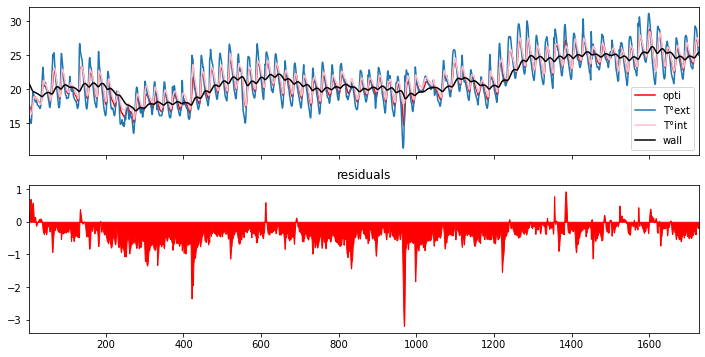

In [226]:
T_theo = solve_2R2C(popt)

# Graphs
T_theo = solve_2R2C(popt)
T_int_theo = T_theo[0, :]
T_wall_theo = T_theo[1, :]


t_min_max = [np.min(time), np.max(time)]
#t_min_max = [200, 300]

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax1.plot(time, T_int_theo, label='opti', color='red')
ax1.plot(time, T_ext, '-', label='T°ext')
ax1.plot(time, T_int, '-', label='T°int', color='pink')
ax1.plot(time, T_wall_theo, label='wall', color='black')
ax1.legend()
ax1.set_xlim(t_min_max);

# Residuals
R = T_int_theo - T_int
ax2.fill_between(time, R, color='r');
ax2.set_title('residuals');
ax2.set_xlim(t_min_max);

In [189]:
print('k/M:', popt[1]/M1)
print('sum square residuals:', np.sum(R**2))

k/M: 0.24906555
sum square residuals: 479.62828249929566


## Next

include sun & weather data

- sun * cloud * view
- T_ambiant vs T_ext ?

